In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
from fbprophet import Prophet
from scipy.interpolate import InterpolatedUnivariateSpline
%matplotlib inline
plt.rcParams.update({'font.size': 18})
import utils
from LinearAlignment import LinearAlignment
from numpy import random
import json

In [122]:
random.seed(50)

In [4]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise

    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id]


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [5]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [6]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    epoch_ind = data.columns.get_loc('epoch')
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data.iloc[0,epoch_ind])) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                j = data.index.get_loc(i)
                data = insert_previous_and_shift(data,feature,j)
    return data

In [7]:
def stretch_simulated_feats(data, stretch,true_feats = 'position',
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    if true_feats == 'position':
        true_feats_list = ['x','y','z']
    elif true_feats == 'velocity':
        true_feats_list = ['Vx','Vy','Vz']
    elif true_feats == 'all':
        true_feats_list = ['x','y','z'] + ['Vx','Vy','Vz']
    else:
        true_feats_list = true_feats
    
    for feature in true_feats_list:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

def amp_sim_feats(data, amp_stretch,feats = ['Vx_sim','Vy_sim','Vz_sim'],
                           suffix="_stretch_amp"):
    '''
    vary amplitude for simulation to better match true data,
    for a single sattelite;
    use predetermined amp_stretch coefficient (depends on the satellite)
    
    '''
    if feats == 'position':
        feats_list = ['x_sim','y_sim','z_sim']
    elif feats == 'velocity':
        feats_list = ['Vx_sim','Vy_sim','Vz_sim']
    elif feats == 'all':
        feats_list = ['x_sim','y_sim','z_sim'] + ['Vx_sim','Vy_sim','Vz_sim']
    else:
        feats_list = feats
        
    for feature in feats_list:
        data[feature+suffix] = amp_stretch*data[feature]
    
    return data

## Loading the data

In [8]:
data = pd.read_csv('data/train.csv', index_col = 'id')
data['time'] = data['epoch']
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)
# data['epoch'] = data['epoch'] - data['epoch'][0]

In [9]:
#data.head(1)

In [10]:
test_data = pd.read_csv('data/test.csv', index_col = 'id')
test_data['time'] = test_data['epoch']
test_data['epoch'] = pd.to_datetime(test_data['epoch']).values.astype(float)
# test_data['epoch'] = test_data['epoch'] - data['epoch'][0]

In [11]:
#test_data.head()

Track 1 train data only

In [12]:
sat_t1 = test_data['sat_id'].unique()
data = data[data['sat_id'].isin(sat_t1)]

In [13]:
all_data = pd.concat([data,test_data],sort=False)

In [14]:
train_index = data.index
test_index = test_data.index
all_index = all_data.index

In [15]:
target_list = ['x','y','z','Vx','Vy','Vz']
feature_list = [t+'_sim' for t in target_list]

### Remove time jumps: track 1

remove_time_jumps_fast on all track1 satellites only, compute smape

In [16]:
pd.options.mode.chained_assignment = None
remove_jumps = pd.DataFrame([])
for sat_id in tqdm(sat_t1):
    sat_data = get_satellite_data(all_data, sat_id)
    sat_data = remove_time_jumps_fast(sat_data)
    remove_jumps = remove_jumps.append(sat_data)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  5.22it/s]


In [17]:
remove_jumps.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time,t,dt
id,,,,,,,,,,,,,,,,,
1819,1.388534e+18,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227,2014-01-01T00:00:00.000,0.000000,NaN
1820,1.388536e+18,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049,2014-01-01T00:21:11.845,0.014720,0.01472
1821,1.388537e+18,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255,2014-01-01T00:42:23.690,0.029441,0.01472
1822,1.388538e+18,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723,2014-01-01T01:03:35.534,0.044161,0.01472
1823,1.388539e+18,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010,2014-01-01T01:24:47.379,0.058882,0.01472


In [18]:
remove_jumps_train = remove_jumps.drop('dt',axis=1).dropna()

In [19]:
remove_jumps_train.shape

(315183, 16)

In [20]:
remove_jumps_test = remove_jumps.loc[~remove_jumps.index.isin(remove_jumps.drop('dt',axis=1).dropna().index)]

In [21]:
remove_jumps_test.shape

(284071, 17)

In [22]:
remove_jumps_train.index.equals(data.index)

True

In [23]:
remove_jumps_test.index.equals(test_data.index)

True

In [24]:
smape_remove_jumps = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_train,sat)
    m = int(0.7*d.shape[0])
    smape_remove_jumps.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Add linear alignment
after having removed time jumps

In [25]:
sat_id = random.choice(sat_t1)
print(sat_id)
# sat_id = 448

357


In [26]:
alignment_model = LinearAlignment()
transf_df = pd.DataFrame([])
for sat_id in tqdm(sat_t1):

    sat_data = get_satellite_data(remove_jumps, sat_id)
    n_first = sat_data.shape[0] - sat_data['x'].isnull().sum()
    index = sat_data.index
    pred = pd.DataFrame(index = index)
    sat_data.set_index(index)

    n_train = 4*len(sat_data) // 10
    train_sat_data = sat_data[:n_train]
    
    pred['epoch'] = sat_data['epoch'].values
    pred['t'] = sat_data['t'].values
    pred['sat_id'] = sat_id
    
    try:
        for feature_name in target_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)

            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            if utils.smape(option1[n_train:n_first],sat_data[feature_name].values[n_train:n_first]) < utils.smape(option2[n_train:n_first],sat_data[feature_name].values[n_train:n_first]):
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=-sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=-sat_data[feature_name].iloc[:n_first].values)

                pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            else:
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=sat_data[feature_name].iloc[:n_first].values)
                pred[f'{feature_name}_sim']  = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            pred.loc[:,feature_name]=sat_data.loc[:, feature_name].values

    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    transf_df = transf_df.append(pred)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:43<00:00,  1.65it/s]


In [27]:
remove_jumps_la = transf_df.copy()
remove_jumps_la_train = remove_jumps_la.dropna()
remove_jumps_la_test = remove_jumps_la.loc[~remove_jumps_la.index.isin
                                           (remove_jumps_la.dropna().index)]

In [28]:
remove_jumps_la_train.index.equals(data.index)

True

In [29]:
remove_jumps_la_test.index.equals(test_data.index)

True

In [30]:
smape_remove_jumps_la = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_la_train,sat)
    m = int(0.7*d.shape[0])
    smape_remove_jumps_la.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

Check tails for all satellites, to be sure LA did not remove any data at end

In [31]:
#check tail on 372,587,523,473,515
threshold = 0.0001
for i in sat_t1:
    if abs(get_satellite_data(remove_jumps_la,i)['Vx_sim'].tail(10).mean()) < threshold:
        print(i)

### Stretch horizontally

Will find one coefficient for x,y,z and another for Vx,Vy,Vz; that is best in terms of smape on train data.

In [32]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [33]:
stretch_dict_vel = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        d = stretch_simulated_feats(d,i,true_feats='velocity',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_vel[sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.12it/s]


In [34]:
extreme_stretch = [k for k,v in stretch_dict_vel.items() if (v <= 0.98 or v >= 1.02)]
extreme_stretch

[26, 35, 252, 277, 391, 515]

In [35]:
for sat in extreme_stretch:
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.94,1.06,0.005):
        d = stretch_simulated_feats(d,i,true_feats = 'velocity')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_vel[sat] = best[0]

In [36]:
extreme_stretch = [k for k,v in stretch_dict_vel.items() if (v <= 0.94 or v >= 1.06)]
extreme_stretch

[]

In [37]:
#stretch_dict_vel = {int(k):v for k,v in stretch_dict_vel.items()}

#save stretch_dict
#import json
#with open('stretch_dict_vel.txt', 'w') as file:
#    json.dump(stretch_dict_vel, file)

with open('stretch_dict_vel.txt', 'r') as file:
    stretch_dict_vel = json.load(file)

In [38]:
#position
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]
stretch_dict_pos = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        d = stretch_simulated_feats(d,i,true_feats='position',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.29it/s]


In [39]:
extreme_stretch = [k for k,v in stretch_dict_pos.items() if (v <= 0.98 or v >= 1.02)]
extreme_stretch

[252, 277, 391, 438, 515]

In [40]:
for sat in extreme_stretch:
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.9,1.1,0.005):
        d = stretch_simulated_feats(d,i,true_feats = 'position')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]

In [41]:
extreme_stretch = [k for k,v in stretch_dict_pos.items() if (v <= 0.9 or v >= 1.1)]
extreme_stretch

[]

In [42]:
#stretch_dict_pos = {int(k):v for k,v in stretch_dict_pos.items()}
#save stretch_dict
#import json
#with open('stretch_dict_pos.txt', 'w') as file:
#    json.dump(stretch_dict_pos, file)

with open('stretch_dict_pos.txt', 'r') as file:
    stretch_dict_pos = json.load(file)

### Horizontal stretch after LA

In [43]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [44]:
stretch_dict_la_vel = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_la_train, sat)
    
    stretch_list = []
    for i in np.arange(0.95,1.05,0.005):
        d = stretch_simulated_feats(d,i,true_feats='velocity',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_la_vel[sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.83it/s]


In [45]:
extreme_stretch = [k for k,v in stretch_dict_la_vel.items() if (v <= 0.95 or v >= 1.05)]
extreme_stretch

[]

In [46]:
#stretch_dict_la_vel = {int(k):v for k,v in stretch_dict_la_vel.items()}
#save stretch_dict
#import json
#with open('stretch_dict_la_vel.txt', 'w') as file:
#    json.dump(stretch_dict_la_vel, file)

with open('stretch_dict_la_vel.txt', 'r') as file:
    stretch_dict_la_vel = json.load(file)

In [47]:
#position
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]
stretch_dict_la_pos = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_la_train, sat)
    
    stretch_list = []
    for i in np.arange(0.96,1.04,0.005):
        d = stretch_simulated_feats(d,i,true_feats='position',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_la_pos[sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 13.89it/s]


In [48]:
extreme_stretch = [k for k,v in stretch_dict_la_pos.items() if (v <= 0.96 or v >= 1.04)]
extreme_stretch

[]

In [49]:
#stretch_dict_la_pos = {int(k):v for k,v in stretch_dict_la_pos.items()}
#save stretch_dict
#import json
#with open('stretch_dict_la_pos.txt', 'w') as file:
#    json.dump(stretch_dict_la_pos, file)

with open('stretch_dict_la_pos.txt', 'r') as file:
    stretch_dict_la_pos = json.load(file)

## Stretch amplitude, individually for each feature

In [50]:
amp_dict_pos = {}
for dim in ['x','y','z']:
    amp_dict_pos[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.50it/s]


In [51]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

{'x': [], 'y': [515], 'z': [515]}

In [52]:
for dim in ['x','y','z']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

In [53]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

{'x': [], 'y': [], 'z': []}

In [54]:
#for dim in ['x','y','z']:
#    amp_dict_pos[dim] = {int(k):v for k,v in amp_dict_pos[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_pos.txt', 'w') as file:
#    json.dump(amp_dict_pos, file)

with open('amp_dict_pos.txt', 'r') as file:
    amp_dict_pos = json.load(file)

In [55]:
amp_dict_vel = {}
for dim in ['Vx','Vy','Vz']:
    amp_dict_vel[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_vel[dim][sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:35<00:00,  8.56it/s]


In [56]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_vel[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

{'Vx': [391, 515], 'Vy': [127, 252], 'Vz': []}

In [57]:
for dim in ['Vx','Vy','Vz']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_vel[dim][sat] = best[0]

In [58]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_vel[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

{'Vx': [], 'Vy': [], 'Vz': []}

In [59]:
for dim in ['Vx','Vy','Vz']:
    amp_dict_vel[dim] = {int(k):v for k,v in amp_dict_vel[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_vel.txt', 'w') as file:
#    json.dump(amp_dict_vel, file)

with open('amp_dict_vel.txt', 'r') as file:
    amp_dict_vel = json.load(file)

## Amplitude stretch after LA and horizontal stretch

In [60]:
amp_dict_la_pos = {}
for dim in ['x','y','z']:
    amp_dict_la_pos[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_la_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_la_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_la_pos[dim][sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.93it/s]


In [61]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_la_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

{'x': [], 'y': [], 'z': []}

In [62]:
#for dim in ['x','y','z']:
#    amp_dict_la_pos[dim] = {int(k):v for k,v in amp_dict_la_pos[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_la_pos.txt', 'w') as file:
#    json.dump(amp_dict_la_pos, file)

with open('amp_dict_la_pos.txt', 'r') as file:
    amp_dict_la_pos = json.load(file)

In [63]:
amp_dict_la_vel = {}
for dim in ['Vx','Vy','Vz']:
    amp_dict_la_vel[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_la_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_la_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_la_vel[dim][sat] = best[0]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.80it/s]


In [64]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_la_vel[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

{'Vx': [], 'Vy': [], 'Vz': []}

In [65]:
#for dim in ['Vx','Vy','Vz']:
#    amp_dict_la_vel[dim] = {int(k):v for k,v in amp_dict_la_vel[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_la_vel.txt', 'w') as file:
#    json.dump(amp_dict_la_vel, file)

with open('amp_dict_la_vel.txt', 'r') as file:
    amp_dict_la_vel = json.load(file)

## Apply stretching to data


1. To `remove_jumps` df

2. Next, to `remove_jumps_la` df

In [66]:
df_list = [get_satellite_data(remove_jumps,i) for i in sat_t1]
len(df_list)

300

In [67]:
#horizontal stretch
for df in df_list:
    df = stretch_simulated_feats(df,stretch_dict_vel[str(int(df['sat_id'].unique()))],true_feats='velocity',suffix='_sim')
    df = stretch_simulated_feats(df,stretch_dict_pos[str(int(df['sat_id'].unique()))],true_feats='position',suffix='_sim')
df.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time,t,dt
id,,,,,,,,,,,,,,,,,
1231060,1.393565e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,77054.582572,-59078.354514,-568.800871,-0.803702,-1.297028,0.163600,2014-02-28T05:19:01.386,58.221544,0.085244
1231061,1.393572e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,70256.332335,-67906.739391,638.268409,-1.037560,-1.095490,0.163476,2014-02-28T07:21:46.454,58.306788,0.085244
1231062,1.393579e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,61829.238915,-75160.476673,1830.266511,-1.246389,-0.869204,0.159549,2014-02-28T09:24:31.522,58.392032,0.085244
1231063,1.393587e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,51953.463644,-80650.378576,2978.927754,-1.431064,-0.616020,0.151705,2014-02-28T11:27:16.590,58.477275,0.085244
1231064,1.393594e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,40809.611234,-84165.238391,4054.152281,-1.590525,-0.332080,0.139551,2014-02-28T13:30:01.658,58.562519,0.085244


In [68]:
#amplitude stretch
for df in df_list:
    for dim in ['Vx','Vy','Vz']:
        #print(dim)
        amp = amp_dict_vel[dim][str(int(df['sat_id'].unique()))]
        #print(amp)
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]
    for dim in ['x','y','z']:
        amp = amp_dict_pos[dim][str(int(df['sat_id'].unique()))]
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]
df.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time,t,dt
id,,,,,,,,,,,,,,,,,
1231060,1.393565e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,77054.582572,-59078.354514,-568.800871,-0.803702,-1.297028,0.163600,2014-02-28T05:19:01.386,58.221544,0.085244
1231061,1.393572e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,70256.332335,-67906.739391,638.268409,-1.037560,-1.095490,0.163476,2014-02-28T07:21:46.454,58.306788,0.085244
1231062,1.393579e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,61829.238915,-75160.476673,1830.266511,-1.246389,-0.869204,0.159549,2014-02-28T09:24:31.522,58.392032,0.085244
1231063,1.393587e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,51953.463644,-80650.378576,2978.927754,-1.431064,-0.616020,0.151705,2014-02-28T11:27:16.590,58.477275,0.085244
1231064,1.393594e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,40809.611234,-84165.238391,4054.152281,-1.590525,-0.332080,0.139551,2014-02-28T13:30:01.658,58.562519,0.085244


In [69]:
remove_jumps_stretch = pd.concat(df_list,axis=0,sort=False)

In [70]:
remove_jumps_stretch_train = remove_jumps_stretch.drop('dt',axis=1).dropna()

In [71]:
remove_jumps_stretch_test = remove_jumps_stretch.loc[~remove_jumps_stretch.index.isin
                                           (remove_jumps_stretch_train.dropna().index)]
remove_jumps_stretch_train.index.equals(data.index)
remove_jumps_stretch_test.index.equals(test_data.index)

True

In [72]:
smape_remove_jumps_stretch = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_stretch_train,sat)
    m = int(0.7*d.shape[0])
    smape_remove_jumps_stretch.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

Now LA and stretch

In [73]:
df_list = [get_satellite_data(remove_jumps_la,i) for i in sat_t1]
len(df_list)

300

In [74]:
#horizontal stretch
for df in df_list:
    df = stretch_simulated_feats(df,stretch_dict_la_vel[str(int(df['sat_id'].unique()))],true_feats='velocity',suffix='_sim')
    df = stretch_simulated_feats(df,stretch_dict_la_pos[str(int(df['sat_id'].unique()))],true_feats='position',suffix='_sim')
df.tail()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
id,,,,,,,,,,,,,,,
1231060,1.393565e+18,58.221544,597,76906.939308,NaN,-59236.403348,NaN,-535.523943,NaN,-0.807110,NaN,-1.292839,NaN,0.163711,NaN
1231061,1.393572e+18,58.306788,597,70065.693017,NaN,-68040.376910,NaN,671.553602,NaN,-1.040613,NaN,-1.090759,NaN,0.163333,NaN
1231062,1.393579e+18,58.392032,597,61600.061178,NaN,-75266.613847,NaN,1862.786813,NaN,-1.249111,NaN,-0.863900,NaN,0.159153,NaN
1231063,1.393587e+18,58.477275,597,51690.108564,NaN,-80725.590472,NaN,3009.871459,NaN,-1.433450,NaN,-0.610073,NaN,0.151035,NaN
1231064,1.393594e+18,58.562519,597,40516.510035,NaN,-84205.829605,NaN,4082.665626,NaN,-1.592554,NaN,-0.325392,NaN,0.138577,NaN


In [75]:
#amplitude stretch
for df in df_list:
    for dim in ['Vx','Vy','Vz']:
        #print(dim)
        amp = amp_dict_la_vel[dim][str(int(df['sat_id'].unique()))]
        #print(amp)
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]
    for dim in ['x','y','z']:
        amp = amp_dict_la_pos[dim][str(int(df['sat_id'].unique()))]
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]

In [76]:
df.tail()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
id,,,,,,,,,,,,,,,
1231060,1.393565e+18,58.221544,597,76906.939308,NaN,-59236.403348,NaN,-535.523943,NaN,-0.807110,NaN,-1.292839,NaN,0.163711,NaN
1231061,1.393572e+18,58.306788,597,70065.693017,NaN,-68040.376910,NaN,671.553602,NaN,-1.040613,NaN,-1.090759,NaN,0.163333,NaN
1231062,1.393579e+18,58.392032,597,61600.061178,NaN,-75266.613847,NaN,1862.786813,NaN,-1.249111,NaN,-0.863900,NaN,0.159153,NaN
1231063,1.393587e+18,58.477275,597,51690.108564,NaN,-80725.590472,NaN,3009.871459,NaN,-1.433450,NaN,-0.610073,NaN,0.151035,NaN
1231064,1.393594e+18,58.562519,597,40516.510035,NaN,-84205.829605,NaN,4082.665626,NaN,-1.592554,NaN,-0.325392,NaN,0.138577,NaN


In [77]:
remove_jumps_la_stretch = pd.concat(df_list,axis=0,sort=False)

In [78]:
remove_jumps_la_stretch_train = remove_jumps_la_stretch.dropna()

In [79]:
remove_jumps_la_stretch_test = remove_jumps_la_stretch.loc[~remove_jumps_la_stretch.index.isin
                                           (remove_jumps_la_stretch_train.dropna().index)]
remove_jumps_la_stretch_train.index.equals(data.index)
remove_jumps_la_stretch_test.index.equals(test_data.index)

True

In [80]:
smape_remove_jumps_la_stretch = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_la_stretch_train,sat)
    m = int(0.7*d.shape[0])
    smape_remove_jumps_la_stretch.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Smape for orignal simulation

In [81]:
smape_original = []
for sat in sat_t1:
    d = get_satellite_data(data,sat)
    m = int(0.7*d.shape[0])
    smape_original.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Remove jumps, stretch, then do LA

First two pieces already in `remove_jumps_stretch` df.

In [82]:
alignment_model = LinearAlignment()
stretch_la_df = pd.DataFrame([])
for sat_id in tqdm(sat_t1):
    try:
        sat_data = get_satellite_data(remove_jumps_stretch, sat_id)
        n_first = sat_data.shape[0] - sat_data['x'].isnull().sum()
        index = sat_data.index
        pred = pd.DataFrame(index = index)
        sat_data.set_index(index)
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    
    n_train = 4*len(sat_data) // 10
    train_sat_data = sat_data[:n_train]
    
    pred['epoch'] = sat_data['epoch'].values
    pred['t'] = sat_data['t'].values
    pred['sat_id'] = sat_id
    
    try:
        for feature_name in target_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)

            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            if utils.smape(option1[n_train:n_first],sat_data[feature_name].values[n_train:n_first]) < utils.smape(option2[n_train:n_first],sat_data[feature_name].values[n_train:n_first]):
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=-sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=-sat_data[feature_name].iloc[:n_first].values)

                pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            else:
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=sat_data[feature_name].iloc[:n_first].values)
                pred[f'{feature_name}_sim']  = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            pred.loc[:,feature_name]=sat_data.loc[:, feature_name].values

    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    stretch_la_df = stretch_la_df.append(pred)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:47<00:00,  1.65it/s]


In [83]:
stretch_la_df.head()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
id,,,,,,,,,,,,,,,
1819,1.388534e+18,0.000000,1,10405.813755,10390.313089,-2771.180760,-2796.458271,3166.926302,3179.562085,2.508879,2.520477,6.152996,6.149930,-2.826227,-2.827599
1820,1.388536e+18,0.014720,1,11199.459274,11195.606833,5105.200658,5078.653968,-848.597754,-839.076593,-1.132222,-1.126667,5.822436,5.826412,-3.250054,-3.255872
1821,1.388537e+18,0.029441,1,8237.279843,8235.556436,11469.206013,11445.904263,-4684.829256,-4680.514023,-3.228498,-3.230227,4.124297,4.126433,-2.700287,-2.704441
1822,1.388538e+18,0.044161,1,3565.004307,3560.149776,15655.733441,15634.195146,-7655.277835,-7654.177182,-3.960607,-3.964696,2.521337,2.520867,-1.976770,-1.978151
1823,1.388539e+18,0.058882,1,-1571.839073,-1580.476891,18044.683022,18023.318335,-9755.479443,-9755.287599,-4.046854,-4.050865,1.298053,1.296388,-1.347061,-1.346512


In [84]:
remove_jumps_stretch_la_train = stretch_la_df.dropna()
remove_jumps_stretch_la_train.shape

(315183, 15)

In [85]:
remove_jumps_stretch_la_test = stretch_la_df.loc[~stretch_la_df.index.isin
                                           (remove_jumps_stretch_la_train.dropna().index)]
remove_jumps_stretch_la_train.index.equals(data.index)
#remove_jumps_stretch_la_test.index.equals(test_data.index)

True

In [86]:
smape_remove_jumps_stretch_la = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_stretch_la_train,sat)
    m = int(0.7*d.shape[0])
    smape_remove_jumps_stretch_la.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Compare SMAPEs

Best choice `best_choice` of transformation for each satellite according to lowest smape in train data.

Code is: 

1. original data \
    `data` (train) and `test_data` (test) <hr>
    
2. yes remove time jumps \
    `remove_jumps_train` and `remove_jumps` <hr>
3. yes remove time jumps, yes LA \
    `remove_jumps_la_train` and `remove_jumps_la` <hr>
4. yes remove time jumps, yes LA, yes stretch (in that order) \
    `remove_jumps_la_stretch_train` and `remove_jumps_la_stretch` <hr>
5. yes remove time jumps, yes stretch \
    `remove_jumps_stretch_train` and `remove_jumps_stretch` <hr>
6. yes remove time jumps, yes stretch, yes LA (in that order) \
    `stretch_la_df_train` and `stretch_la_df`

In [87]:
satellites_and_smapes = [sat_t1, smape_original,smape_remove_jumps,smape_remove_jumps_la,
                        smape_remove_jumps_la_stretch,smape_remove_jumps_stretch,
                        smape_remove_jumps_stretch_la]

In [88]:
smapes_all = list(zip(sat_t1, smape_original,smape_remove_jumps,smape_remove_jumps_la,
                        smape_remove_jumps_la_stretch,smape_remove_jumps_stretch,
                        smape_remove_jumps_stretch_la))
len(smapes_all)

300

In [89]:
best_choice = []
for i in range(len(sat_t1)):
    best_choice.append((smapes_all[i][0],smapes_all[i].index(min(smapes_all[i]))))

## Submission with best transformation by satellite

In [ ]:
# best_choice_map = {1:test_data,2:remove_jumps_test,3:remove_jumps_la_test,
#                    4:remove_jumps_la_stretch_test,5:remove_jumps_stretch_test,
#                    6:remove_jumps_stretch_la_test}

In [91]:
best_choice_map = {1:all_data,2:remove_jumps,3:remove_jumps_la,
                   4:remove_jumps_la_stretch,5:remove_jumps_stretch,
                   6:stretch_la_df}

In [126]:
best = pd.DataFrame([])
i=0
for sat in sat_t1:
  #  if i < 1:
   #     print(i, best_choice[i][1])
    d = best_choice_map[best_choice[i][1]][feature_list+['sat_id']]
   # if i < 1:
   #     print(d.shape)
    d = d[d['sat_id']==sat]
   # if i < 1:
    #    print(d[feature_list].columns)
    best = best.append(d)
    #if i < 1:
     #   print(submission_best_transformation.shape)
    i += 1

In [129]:
best.head()

,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,sat_id
id,,,,,,,
1819,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227,1
1820,11199.459274,5105.200658,-848.597754,-1.132222,5.822436,-3.250054,1
1821,8237.279843,11469.206013,-4684.829256,-3.228498,4.124297,-2.700287,1
1822,3565.004307,15655.733441,-7655.277835,-3.960607,2.521337,-1.976770,1
1823,-1571.839073,18044.683022,-9755.479443,-4.046854,1.298053,-1.347061,1


In [131]:
index = all_data.index
for label in target_list:
    best.loc[index, label] = all_data.loc[index,label]
best.loc[index, 'epoch']= all_data.loc[index,'epoch']
best.loc[index, 't']= remove_jumps.loc[index,'t']
best.head()


,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,sat_id,x,y,z,Vx,Vy,Vz,epoch,t
id,,,,,,,,,,,,,,,
1819,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,1.388534e+18,0.000000
1820,11199.459274,5105.200658,-848.597754,-1.132222,5.822436,-3.250054,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,1.388536e+18,0.014720
1821,8237.279843,11469.206013,-4684.829256,-3.228498,4.124297,-2.700287,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,1.388537e+18,0.029441
1822,3565.004307,15655.733441,-7655.277835,-3.960607,2.521337,-1.976770,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,1.388538e+18,0.044161
1823,-1571.839073,18044.683022,-9755.479443,-4.046854,1.298053,-1.347061,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,1.388539e+18,0.058882


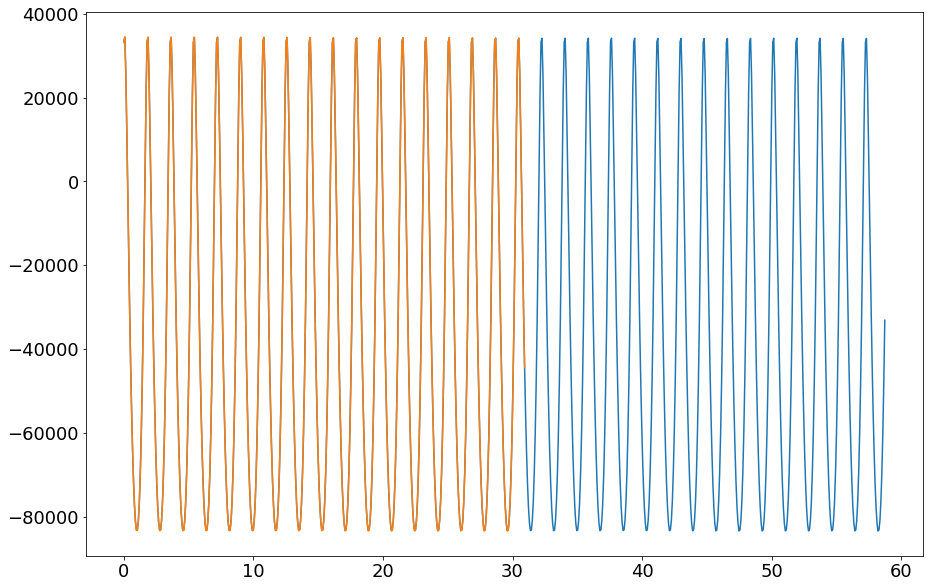

In [132]:
plt.figure(figsize = (15,10))
m_data = best[best.sat_id == 2]
plt.plot(m_data['t'], m_data['x_sim'])
plt.plot(m_data['t'], m_data['x'])

In [133]:
target_list

['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

In [177]:
best_1 = pd.DataFrame([])
i=0
for sat in [372,473,514]:
  #  if i < 1:
   #     print(i, best_choice[i][1])
    d = best_choice_map[5][feature_list+['sat_id']]
   # if i < 1:
   #     print(d.shape)
    d = d[d['sat_id']==sat]
   # if i < 1:
    #    print(d[feature_list].columns)
    best_1 = best_1.append(d)
    #if i < 1:
     #   print(submission_best_transformation.shape)
    i += 1
for sat in [587]:
  #  if i < 1:
   #     print(i, best_choice[i][1])
    d = best_choice_map[1][feature_list+['sat_id']]
   # if i < 1:
   #     print(d.shape)
    d = d[d['sat_id']==sat]
   # if i < 1:
    #    print(d[feature_list].columns)
    best_1 = best_1.append(d)
    #if i < 1:
     #   print(submission_best_transformation.shape)
    i += 1
index = all_data[all_data.sat_id.isin([372,587,473,514])].index
for label in target_list:
    best_1.loc[index, label] = all_data.loc[index,label]
best_1.loc[index, 'epoch']= all_data.loc[index,'epoch']
best_1.loc[index, 't']= remove_jumps.loc[index,'t']
best_1.head()

,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,sat_id,x,y,z,Vx,Vy,Vz,epoch,t
id,,,,,,,,,,,,,,,
746351,-7860.046460,-3132.109662,2904.845788,-2.248154,6.610960,1.041413,372,-7864.678484,-3129.694640,2907.635431,-2.245256,6.608261,1.039890,1.388534e+18,0.000000
746352,-8408.384650,-221.380394,3195.033561,-0.323371,7.008780,0.318784,372,-8412.117022,-220.195147,3197.249996,-0.322000,7.005179,0.317406,1.388535e+18,0.004906
746353,-8138.889636,2712.535682,3174.147312,1.569253,6.726703,-0.410586,372,-8142.359815,2712.345768,3175.824997,1.569116,6.723347,-0.411696,1.388535e+18,0.009812
746354,-7114.320644,5397.827305,2858.516662,3.208626,5.859393,-1.059693,372,-7118.319697,5395.817612,2859.815398,3.207649,5.855679,-1.061148,1.388536e+18,0.014718
746355,-5474.803399,7620.801613,2295.605579,4.455283,4.576093,-1.570595,372,-5478.816040,7618.661585,2296.340781,4.454570,4.574468,-1.571567,1.388536e+18,0.019624


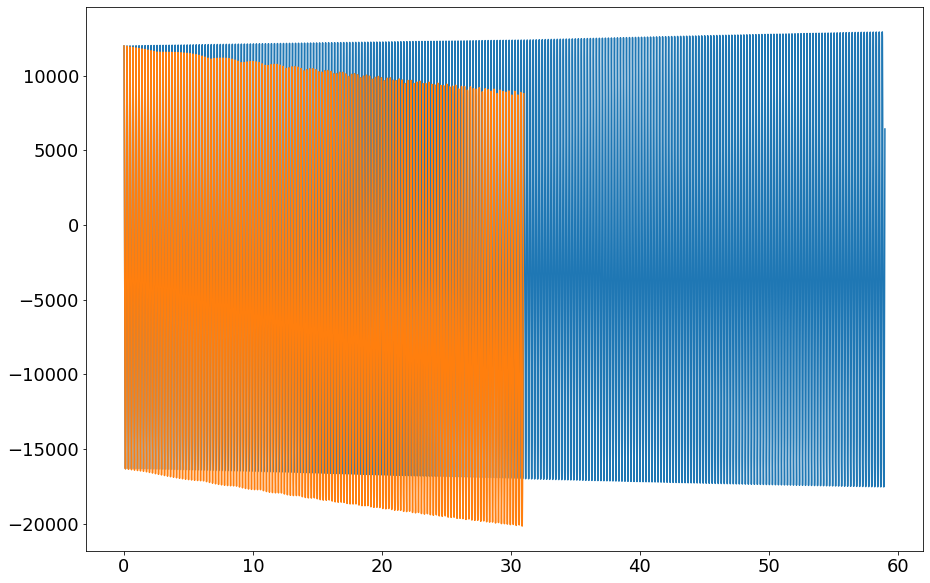

In [178]:
plt.figure(figsize = (15,10))
m_data = best_1[best_1.sat_id == 587]
plt.plot(m_data['t'], m_data['x_sim'])
plt.plot(m_data['t'], m_data['x'])

# Prophet()

In [184]:
fail_list = []
# satellites_list = transf_df['sat_id'].unique()
# res = pd.DataFrame([])
# for sat_id in tqdm(sat_t1):
for sat_id in tqdm([372,587,473,514]):    
    
    
    sat_data = best_1[best_1.sat_id == sat_id]
    
    n_train = 4* len(sat_data) // 10
    n_first = len(sat_data[~pd.isna(sat_data.x)])

    pred = pd.DataFrame(index = sat_data.iloc[n_first:].index)
    pred['epoch'] = sat_data['epoch'].iloc[n_first:].values
    pred['t'] = sat_data['t'].iloc[n_first:].values
    pred['sat_id'] = sat_id

#     if sat_id in [26]:
#         for feature_name in target_list:
#             pred[feature_name] = sat_data[f'{feature_name}_sim'].values
#     else:
    try:

        for feature_name in target_list:

            q = InterpolatedUnivariateSpline(sat_data['t'][:n_train], sat_data[f'{feature_name}_sim'][:n_train]).roots()
            T = (q[2]-q[0])

            # create a DataFrame for prophet model()
            ts = pd.DataFrame([])
            ts['ds'] = pd.to_datetime(sat_data ['epoch']).values
            ts['y'] = sat_data [feature_name].values-sat_data [f'{feature_name}_sim'].values

            # define the time frame for the first forecast 
            future =ts[n_train:n_first] [['ds']]

            # define the model
            m = Prophet(changepoint_prior_scale = T/20,
            weekly_seasonality = False,
            yearly_seasonality = False).add_seasonality(name='grid', period = T, fourier_order=50)

            #fit the model and make the forecast
            m.fit(ts[:n_train])
            forecast = m.predict(future)

            new_values = sat_data.loc[:,f'{feature_name}_sim'].iloc[n_train:n_first].values+forecast.loc[:, 'yhat'].values

            option1 = sat_data[f'{feature_name}_sim'].values


            option2 = np.concatenate((sat_data[f'{feature_name}_sim'].values[:n_train], new_values), axis=None)


            print('{}[{}]  no correction: {}, correction:{}'.format(sat_id,
                                                                feature_name,
                                                                utils.smape(option1[n_train:n_first],sat_data[feature_name].iloc[n_train:n_first].values),
                                                                utils.smape(option2[n_train:n_first],sat_data[feature_name].iloc[n_train:n_first].values)))

            if utils.smape(option1[n_train:n_first],sat_data[feature_name].iloc[n_train:n_first].values) < utils.smape(option2[n_train:n_first],sat_data[feature_name].iloc[n_train:n_first].values):
                pred[feature_name] = option1[n_first:]
                print(sat_id, feature_name, 'does not work')
                fail_list.append((sat_id, feature_name))
            else:
                # fit a new model on the whole training range

                # define the time frame for the first forecast 
                future =ts[n_first:] [['ds']]

                # define the model
                m = Prophet(changepoint_prior_scale = T/20,
                weekly_seasonality = False,
                yearly_seasonality = False).add_seasonality(name='grid', period = T, fourier_order=50)

                #fit the model and make the forecast
                m.fit(ts[:n_first])
                forecast = m.predict(future)

                pred[feature_name]  = sat_data.loc[:,f'{feature_name}_sim'].iloc[n_first:].values+forecast.loc[:, 'yhat'].values





    except Exception as e:
        print(f'phophet failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

#     sat_sim_smape = utils.smape(sat_data.loc[n_train:, [f'{f}_sim' for f in features_list]].values,
#                                 sat_data.loc[n_train:, features_list].values)
#     sat_new_smape = utils.smape(pred.loc[n_train:, features_list].values,
#                                 sat_data.loc[n_train:, features_list].values)
#     result_df.append([sat_id, sat_sim_smape, sat_new_smape])
    res = res.append(pred, sort=False)


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

372[x]  no correction: 0.47314769699532344, correction:0.8147674984159842
372 x does not work
372[y]  no correction: 0.47179603596177566, correction:0.7829036477860563
372 y does not work
372[z]  no correction: 0.4701036038901174, correction:0.8017488087722251
372 z does not work
372[Vx]  no correction: 0.47327525708711704, correction:0.7703037770041228
372 Vx does not work
372[Vy]  no correction: 0.47427645864597023, correction:0.8364101491078627
372 Vy does not work
372[Vz]  no correction: 0.4717968134250936, correction:0.7681637583702386
372 Vz does not work



 25%|█████████████████████                                                               | 1/4 [00:59<02:58, 59.50s/it]

587[x]  no correction: 0.5198461535932867, correction:0.6464800865223452
587 x does not work
587[y]  no correction: 0.5140342565753254, correction:0.5990630030059643
587 y does not work
587[z]  no correction: 0.5073191908273499, correction:0.535223260370483
587 z does not work
587[Vx]  no correction: 0.51729692347224, correction:0.6888266110094428
587 Vx does not work
587[Vy]  no correction: 0.5170355484038015, correction:0.6374718746355753
587 Vy does not work
587[Vz]  no correction: 0.5221810919411196, correction:0.5036024236246717



 50%|██████████████████████████████████████████                                          | 2/4 [02:03<02:01, 60.88s/it]

473[x]  no correction: 0.8323707158108656, correction:0.28670472365655525
473[y]  no correction: 0.8708780787145398, correction:0.29168367833869063
473[z]  no correction: 0.9051266034188734, correction:0.5267099384045308
473[Vx]  no correction: 0.9314385095289089, correction:0.3987099800461531
473[Vy]  no correction: 0.9058757456400861, correction:0.38911105223651216
473[Vz]  no correction: 0.893219525802869, correction:0.6845374357570998



 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [06:21<02:00, 120.07s/it]

514[x]  no correction: 0.6020792035225818, correction:0.5092419359962616
514[y]  no correction: 0.6752709669378205, correction:0.6744759613760094
514[z]  no correction: 0.6206731245172906, correction:0.6090373340004741
514[Vx]  no correction: 0.26777403806303834, correction:0.3712461767166566
514 Vx does not work
514[Vy]  no correction: 0.2666216628928308, correction:0.3919204488873376
514 Vy does not work
514[Vz]  no correction: 0.2691472915111961, correction:0.38357390564224886
514 Vz does not work



100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:18<00:00, 100.95s/it]

In [137]:
# res.to_csv('temp.csv')

In [185]:
res.shape

(284071, 9)

In [186]:
# res = res[~res.sat_id.isin([372,587,473,514])]
# res.shape

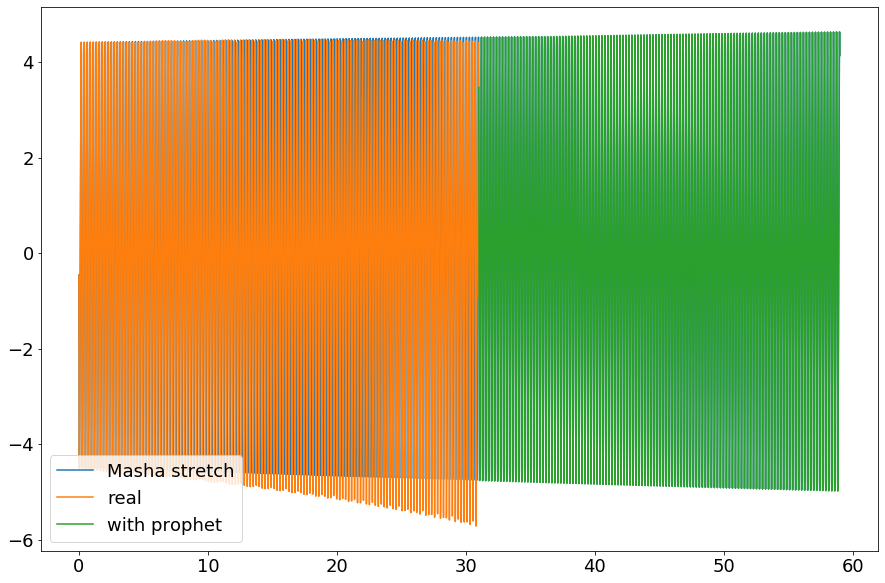

In [196]:
plt.figure(figsize = (15,10))
s_id = 587
m_data = best_1[best_1.sat_id == s_id]
plt.plot(m_data['t'], m_data['Vx_sim'], label = 'Masha stretch')
plt.plot(m_data['t'], m_data['Vx'], label = 'real')
plt.plot(res[res.sat_id == s_id]['t'],res[res.sat_id == s_id]['Vx'] , label = 'with prophet')
plt.legend()

In [197]:
sub = pd.read_csv('data/submission.csv', index_col = 'id')
sub.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [202]:
sub.shape

(284071, 6)

In [200]:
sumission_index = sub.index
df = res.loc[sumission_index,:]
df = df.drop(columns = ['epoch','t','sat_id'])

In [201]:
df.to_csv('submission_12.csv')

In [203]:
df.shape

(284071, 6)